# Exam Code for ISDS 2022

##### Below is the code for our exam project. In this script you will find:
- Importing packages
- Importing and rinsing Twitter data
- Importing and rinsing Crypto data
- ML 
- General plots
- Plots for descriptive statistics

## Downloading Packages

In [45]:
!pip install -q snscrape
!pip install vaderSentiment
!pip install yfinance

In [46]:
import snscrape.modules.twitter as sntwitter
import os
import pandas as pd
import numpy as np
import re
from datetime import date
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib
from requests import Request, Session
import json
import time
import webbrowser
import pprint
import yfinance as yf
import matplotlib as mp
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import calendar

# Twitter data

In [47]:
maxTweets = 500

tweets_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:elonmusk bitcoin OR BTC OR dogecoin OR doge').get_items()):
    if i>maxTweets:
        break
    tweets_list.append([tweet.date, tweet.id, tweet.user.username, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount])
    
tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Username', 'Text', 'Comments', 'Retweets', 'Likes'])

tweets_df

tweets_df.to_csv('elon_tweets.csv', encoding='utf-8', index=False)

### Rinsing Twitter data

In [48]:
df = pd.read_csv('elon_tweets.csv', encoding='utf-8')


def cleaner(data):
    data = data.lower() 
    data = re.sub(r'@\w+','', data) 
    return data

df['Text'] = df['Text'].apply(cleaner)


### Dummy variables for Dodgecoin and Bitcoin

In [49]:
bitcoin = ["bitcoin", "BTC"]
dogecoin = ["dogecoin", "doge"]
lsts = [bitcoin, dogecoin]

In [50]:
import re
def get_dummy_vars(col, lsts):
    out = []
    len_lsts = len(lsts)
    for row in col:
        tmp = []
        for lst in lsts:
            tmp.append(int(any(True for x in lst if re.search(fr"\b{x}\b", row))))
            if tmp[-1]:
                break
        tmp += [0] * (len_lsts - len(tmp))
        out.append(tmp)
    return out


twit = df.join(pd.DataFrame(get_dummy_vars(df['Text'], lsts), columns=['bitcoin', 'dogecoin']))

In [51]:
twit['bitcoin']=twit['bitcoin'].astype(int)
twit['dogecoin']=twit['dogecoin'].astype(int)

twit_sum = twit['bitcoin'] + twit['dogecoin']

twit = twit.drop(twit[twit_sum ==0].index)
twit = twit.reset_index(drop=True)

### Sentiment analysis for Twitter Data

In [52]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict['compound']

tweets = twit["Text"]

results = []

for i in tweets:
    sent = sentiment_scores(i)
    results.append(sent)
    
twit["Sentiment"] = results

# Crypto Data

In [53]:
def importcryptodata(ticker, startdate, enddate):  
    data = yf.download(ticker, start=startdate, end=enddate, interval='1D') #Tickr input in "", start- enddate in format "YY-MM-DD"
    df = pd.DataFrame(data)
    return df

BTCData = importcryptodata("BTC-USD", "2018-10-01","2022-08-01")
DOGEData = importcryptodata("DOGE-USD", "2018-10-01","2022-08-01")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Bitcoin data

In [54]:
BTC_hourly_returns = BTCData['Adj Close'].pct_change()
BTCData['Day Returns'] = BTC_hourly_returns                           
BTCData['DummyReturn'] = (BTCData['Day Returns'] > 0).astype(int) 

BTCData.iloc[1:,:] 

,Open,High,Low,Close,Adj Close,Volume,Day Returns,DummyReturn
Date,,,,,,,,
2018-10-01,6619.850098,6653.299805,6549.080078,6589.620117,6589.620117,4000970000,-0.005424,0
2018-10-02,6593.240234,6611.839844,6537.899902,6556.100098,6556.100098,3979260000,-0.005087,0
2018-10-03,6553.859863,6571.459961,6454.029785,6502.589844,6502.589844,3887310000,-0.008162,0
2018-10-04,6497.910156,6603.310059,6497.910156,6576.689941,6576.689941,3838410000,0.011395,1
2018-10-05,6574.149902,6623.620117,6557.410156,6622.479980,6622.479980,3671500000,0.006962,1
...,...,...,...,...,...,...,...,...
2022-07-27,21244.169922,22986.529297,21070.806641,22930.548828,22930.548828,31758955233,0.079605,1
2022-07-28,22933.640625,24110.470703,22722.265625,23843.886719,23843.886719,40212386158,0.039831,1
2022-07-29,23845.212891,24294.787109,23481.173828,23804.632812,23804.632812,35887249746,-0.001646,0


#### Making dummy for outlier

In [55]:
BTCData.reset_index(inplace=True)
BTCData['Corona Dummy'] = (BTCData['Date'] == '2020-03-12').astype(int)

#### Selecting only the variables we need for Bitcoin

In [56]:
BTCData = pd.DataFrame(BTCData, columns= ['Date','Day Returns','DummyReturn', 'Corona Dummy'])

### Doge data

In [57]:
DOGE_hourly_returns = DOGEData['Adj Close'].pct_change()
DOGEData['Day Returns'] = DOGE_hourly_returns                           
DOGEData['DummyReturn'] = (DOGEData['Day Returns'] > 0).astype(int)     
DOGEData.iloc[1:,:]

,Open,High,Low,Close,Adj Close,Volume,Day Returns,DummyReturn
Date,,,,,,,,
2018-10-01,0.005901,0.006024,0.005881,0.005942,0.005942,20096400,0.006096,1
2018-10-02,0.005927,0.005964,0.005789,0.005824,0.005824,15357200,-0.019859,0
2018-10-03,0.005813,0.005826,0.005655,0.005704,0.005704,15933900,-0.020604,0
2018-10-04,0.005712,0.005767,0.005576,0.005645,0.005645,14529600,-0.010344,0
2018-10-05,0.005647,0.005744,0.005625,0.005669,0.005669,12566200,0.004252,1
...,...,...,...,...,...,...,...,...
2022-07-27,0.062514,0.067021,0.061886,0.067021,0.067021,499204589,0.072130,1
2022-07-28,0.067031,0.070577,0.065591,0.069108,0.069108,650983024,0.031140,1
2022-07-29,0.069104,0.072004,0.067549,0.068909,0.068909,696887711,-0.002880,0


#### Making dummy for outlier

In [58]:
DOGEData.reset_index(inplace=True)
DOGEData['Reddit Dummy'] = (DOGEData['Date'] == '2021-01-22').astype(int)

#### Selecting only the variables we need for Doge

In [59]:
DOGEData = pd.DataFrame(DOGEData, columns= ['Date', 'Day Returns','DummyReturn', 'Reddit Dummy'])

# Changing Datetime variables

In [60]:
twit['datetime_dt'] = pd.to_datetime(twit['Datetime'], format = '%Y-%m-%d %H:%M:%S')
twit['month'] = twit['datetime_dt'].dt.month
twit['year'] = twit['datetime_dt'].dt.year
twit['day'] = twit['datetime_dt'].dt.day

In [61]:
DOGEData['datetime_dt'] = pd.to_datetime(DOGEData['Date'], format = '%Y-%m-%d %H:%M:%S')
DOGEData['month'] = DOGEData['datetime_dt'].dt.month
DOGEData['day'] = DOGEData['datetime_dt'].dt.day
DOGEData['year'] = DOGEData['datetime_dt'].dt.year

In [62]:
BTCData['datetime_dt'] = pd.to_datetime(BTCData['Date'], format = '%Y-%m-%d %H:%M:%S')
BTCData['month'] = BTCData['datetime_dt'].dt.month
BTCData['day'] = BTCData['datetime_dt'].dt.day
BTCData['year'] = BTCData['datetime_dt'].dt.year

# Merging Crypto- and Twitter data

### Bitcoin and Twitter

In [64]:
on = ['day', 'month', 'year']
BT=BTCData.merge(twit, on= on , how = 'left')

### Doge and Twitter

In [65]:
DT=DOGEData.merge(twit, on = on , how = 'left')

# Machine Learning Bitcoin 

### Extra variables for Bitcoin

In [67]:
BT['Sentiment'] = BT['Sentiment'].replace(np.NaN, 0)
BT['Day Returns'] = BT['Day Returns'].replace(np.NaN, 0)
BT['Likes'] = BT['Likes'].replace(np.NaN, 0)
BT['Comments'] = BT['Comments'].replace(np.NaN, 0)
BT['Retweets'] = BT['Retweets'].replace(np.NaN, 0)
BT['b1'] = BT['Corona Dummy']
BT['b2'] = BT['Sentiment'] * BT['Likes']
BT['b3'] = BT['Sentiment'] * BT['Comments']
BT['b4'] = BT['Sentiment'] * BT['Retweets']
BT['lag'] = BT['Day Returns'].shift(-7)
BT['lag'] = BT['lag'].replace(np.NaN, 0)

### Dividing into Training and test 

In [68]:
dev_set, test_set= np.split(BT, [int(.67 *len(BT))])
train_set, val_set= np.split(dev_set, [int(0.5 *len(dev_set))])

#### Selecting variables

In [69]:
X_dev = pd.DataFrame(data=dev_set, columns=['lag','Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_dev = pd.DataFrame(data=dev_set, columns=['Day Returns'])

X_test = pd.DataFrame(data=test_set, columns=['lag','Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_test = pd.DataFrame(data=test_set, columns=['Day Returns'])

X_train = pd.DataFrame(data=train_set, columns=['lag','Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_train = pd.DataFrame(data=train_set, columns=['Day Returns'])

X_val = pd.DataFrame(data=val_set, columns=['lag','Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_val = pd.DataFrame(data=val_set, columns=['Day Returns'])

### OLS

In [70]:
pipe_lr = make_pipeline(PolynomialFeatures(degree=2, include_bias=True), StandardScaler(), LinearRegression())
pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [71]:
print('LinReg', round(mse(pipe_lr.predict(X_test),y_test), 10))

LinReg 10189.9278394008


### Lasso using Cross Validation

In [72]:
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-10, 10, 66)

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=161193))            
        X_train, y_train = np.array(X_dev)[train_idx], np.array(y_dev)[train_idx]
        X_val, y_val = np.array(X_dev)[val_idx], np.array(y_dev)[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.679e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.395e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.463e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.130e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.242e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.364e-02, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.907e-04, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

In [73]:
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=161193))
pipe_lassoCV.fit(X_dev,y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0.004923882631706742, random_state=161193))])

In [74]:
models = {'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 50))

Lasso CV 0.00154620799343975
LinReg 10189.927839400785


### Elastic net

In [75]:
pipe_el = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        ElasticNet())

gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':lambdas,
                              'elasticnet__l1_ratio':np.linspace(0,1,20)}, 
                  scoring='neg_mean_squared_error', 
                  cv=10)

models['ElasticNetCV'] = gs.fit(X_dev, y_dev)

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.386e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.385e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.386e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.382e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.387e-01, tolerance: 1.284e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.691e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.371e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.691e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.368e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.690e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.343e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.584e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.688e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.263e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.312e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.191e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.584e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.692e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.192e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.264e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.696e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.311e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.695e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.749e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.681e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.262e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.208e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.751e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.899e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.310e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.583e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.695e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.262e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.215e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.432e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.747e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.671e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.189e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.067e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.427e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.695e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.747e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.896e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.043e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.426e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.579e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.690e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.892e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.257e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.184e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.577e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.697e-01, tolerance: 1.355e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.435e-01, tolerance: 1.162e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.675e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.189e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.001e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.425e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.891e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.255e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.574e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.683e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.679e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.422e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.247e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.233e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.175e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.567e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.427e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.669e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.255e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.772e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.728e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.885e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.671e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.416e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.406e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.537e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.500e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.163e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.395e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.463e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.669e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.188e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.251e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.472e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.874e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.237e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.159e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.549e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.393e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.677e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.141e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.530e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.832e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.193e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.362e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.624e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.255e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.749e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.228e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.656e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.840e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.589e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.357e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.010e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.095e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.130e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.283e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.415e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.593e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.368e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.279e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.320e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.505e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.744e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.009e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.388e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.015e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.006e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.932e-01, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.130e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.242e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.653e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.403e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.517e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.306e-01, tolerance: 1.162e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.688e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e-01, tolerance: 1.272e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.281e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

KeyboardInterrupt: 

In [ ]:
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 10))
print()
print('CV params:', gs.best_params_)

### R squared

#### Calculating the R squared for all models, are done by regressing each model  one after another, using the X and y

In [76]:
r_squared = model.score(X_dev, y_dev)

### Learning Curve

In [77]:
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

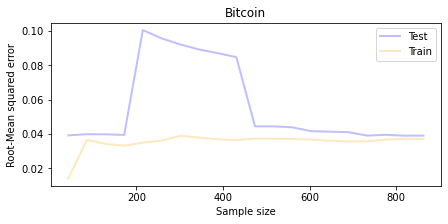

In [78]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Bitcoin')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Sample size')
ax.legend();

### Validation Curve

In [79]:
train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',                 
                     cv=10)

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))


/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.431e-01, tolerance: 1.304e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.581e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.463e-01, tolerance: 1.319e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e-04, tolerance: 1.255e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.585e-01, tolerance: 1.334e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.673e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.647e-01, tolerance: 1.355e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e-01, tolerance: 1.368e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.737e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.569e-01, tolerance: 1.397e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.385e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e-01, tolerance: 1.284e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

lambda
0.004924    0.001516
Name: Validation, dtype: float64


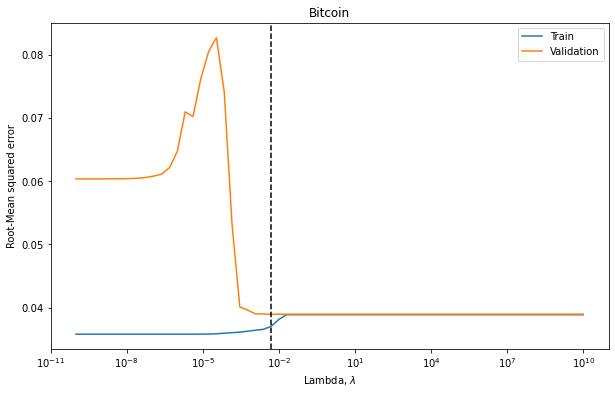

In [80]:

ax = np.sqrt(mse_score).plot(logx=True, figsize=(10,6));
ax.set_title('Bitcoin')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Lambda, $\lambda$')

plt.axvline(x = 0.0049, linestyle = '--', color = 'black')

# Machine Learning Dogecoin

### Extra variables for Dogecoin

In [81]:
DT['Sentiment'] = DT['Sentiment'].replace(np.NaN, 0)
DT['Day Returns'] = DT['Day Returns'].replace(np.NaN, 0)
DT['Likes'] = DT['Likes'].replace(np.NaN, 0)
DT['Comments'] = DT['Comments'].replace(np.NaN, 0)
DT['Retweets'] = DT['Retweets'].replace(np.NaN, 0)

DT['b1'] = DT['Reddit Dummy']
DT['b2'] = DT['Sentiment'] * DT['Likes']
DT['b3'] = DT['Sentiment'] * DT['Comments']
DT['b4'] = DT['Sentiment'] * DT['Retweets']
DT['lag'] = DT['Day Returns'].shift(-7)
DT['lag'] = DT['lag'].replace(np.NaN, 0)

### Dividing into training and test set

In [82]:
dev_set, test_set= np.split(DT, [int(.67 *len(DT))])
train_set, val_set= np.split(dev_set, [int(0.5 *len(dev_set))])

#### Selecting variables

In [83]:
X_dev = pd.DataFrame(data=dev_set, columns=['lag', 'Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_dev = pd.DataFrame(data=dev_set, columns=['Day Returns'])

X_test = pd.DataFrame(data=test_set, columns=['lag', 'Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_test = pd.DataFrame(data=test_set, columns=['Day Returns'])

X_train = pd.DataFrame(data=train_set, columns=['lag', 'Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_train = pd.DataFrame(data=train_set, columns=['Day Returns'])

X_val = pd.DataFrame(data=val_set, columns=['lag', 'Sentiment', 'b1', 'b2', 'b3', 'b4'])          
y_val = pd.DataFrame(data=val_set, columns=['Day Returns'])

### OLS

In [84]:
pipe_lr = make_pipeline(PolynomialFeatures(degree=2, include_bias=True), StandardScaler(), LinearRegression())
pipe_lr.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [85]:
print('LinReg', round(mse(pipe_lr.predict(X_test),y_test), 10))

LinReg 3157.3048428939


### Lasso using cross validation

In [86]:
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-10, 10, 66)

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:    
    
    # Inner loop: folds
    mseCV_ = []    
    for train_idx, val_idx in folds:        
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=161193))            
        X_train, y_train = np.array(X_dev)[train_idx], np.array(y_dev)[train_idx]
        X_val, y_val = np.array(X_dev)[val_idx], np.array(y_dev)[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # Store result    
    mseCV.append(mseCV_) 
    
# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.854e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.967e+00, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.848e+00, tolerance: 1.826e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.004e+00, tolerance: 1.854e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.019e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.022e+00, tolerance: 1.864e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.032e+00, tolerance: 1.865e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.780e+00, tolerance: 1.866e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e+00, tolerance: 4.188e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.744e+00, tolerance: 1.865e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e+00, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

In [87]:
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
pipe_lassoCV = make_pipeline(PolynomialFeatures(include_bias=False), 
                             StandardScaler(),
                             Lasso(alpha=optimal_lambda.index[0], random_state=161193))
pipe_lassoCV.fit(X_dev,y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0.02030917620904739, random_state=161193))])

In [88]:
models = {'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lr}

for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 50))

Lasso CV 0.004777720832016796
LinReg 3157.30484289386


### Elastic Net

In [89]:
pipe_el = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        ElasticNet())

gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':lambdas,
                              'elasticnet__l1_ratio':np.linspace(0,1,20)}, 
                  scoring='neg_mean_squared_error', 
                  cv=10)

models['ElasticNetCV'] = gs.fit(X_dev, y_dev)

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.854e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+00, tolerance: 4.188e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.661e+00, tolerance: 1.606e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.018e+00, tolerance: 1.857e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.060e+00, tolerance: 1.865e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.967e+00, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.018e+00, tolerance: 1.857e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+00, tolerance: 4.188e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.661e+00, tolerance: 1.606e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.967e+00, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.848e+00, tolerance: 1.826e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.018e+00, tolerance: 1.857e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+00, tolerance: 4.188e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.661e+00, tolerance: 1.606e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.967e+00, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.848e+00, tolerance: 1.826e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.854e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.060e+00, tolerance: 1.865e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.967e+00, tolerance: 1.850e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.854e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.066e+00, tolerance: 1.866e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+00, tolerance: 4.188e-04
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

KeyboardInterrupt: 

In [90]:
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 100))
print()
print('CV params:', gs.best_params_)

Lasso CV 0.004777720832016796
LinReg 3157.30484289386



AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

### R squared

#### Calculating the R squared for all models, are done by regressing each model one after another, using the X and y

In [91]:
r_squared = model.score(X_dev, y_dev)

### Learning curve

In [92]:
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

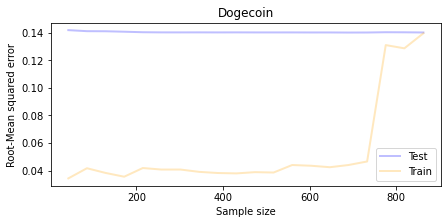

In [93]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Dogecoin')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Sample size')
ax.legend();

### Validation curve

In [94]:
train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', 
                     param_range=lambdas, 
                     scoring='neg_mean_squared_error',                 
                     cv=10)


mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))


/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.854e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+00, tolerance: 1.854e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.946e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.866e+00, tolerance: 1.858e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.056e+00, tolerance: 1.864e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.056e+00, tolerance: 1.864e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.944e+00, tolerance: 1.865e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.822e+00, tolerance: 1.865e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.848e+00, tolerance: 1.826e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.848e+00, tolerance: 1.826e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.926e+00, tolerance: 1.866e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.780e+00, tolerance: 1.866e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.661e+00, tolerance: 1.606e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.661e+00, tolerance: 1.606e-03
  model = cd_fast.enet_coordinate_descent(
/Users/Mille/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

lambda
0.020309    0.019679
Name: Validation, dtype: float64


In [ ]:
ax = np.sqrt(mse_score).plot(logx=True, figsize=(10,6));
ax.set_title('Dogecoin')
ax.set_ylabel('Root-Mean squared error')
ax.set_xlabel('Lambda, $\lambda$')

plt.axvline(x = 0.020309, linestyle = '--', color = 'black')

# General plots

### Bitcoin

Text(0.5, 1.0, 'Bitcoin')

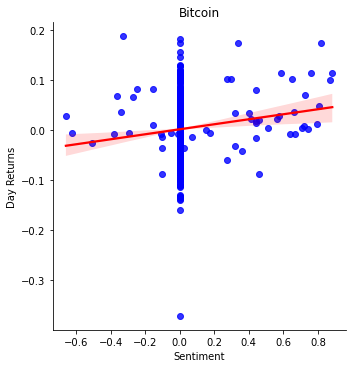

In [95]:
sns.lmplot(x="Sentiment", y="Day Returns", data=BT, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("Bitcoin")

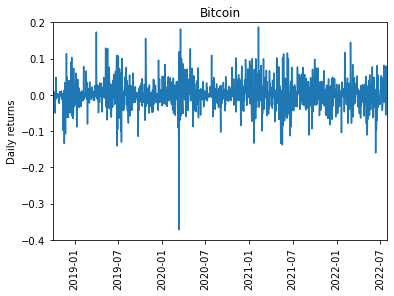

In [96]:
BT_fig = BT[["Date", "bitcoin", "year"]]
BT_fig = BT_fig[BT_fig["bitcoin"]==1]
BT_fig = BT_fig[BT_fig["year"]==2021]

BTdates2021 = BT_fig["Date"].tolist()
BTdates2021 = list(dict.fromkeys(BTdates2021))

BTdate=BT["Date"]
BTdr = BT["Day Returns"]
BTC = BT["bitcoin"]

plt.plot(BTdate,BTdr)
 
plt.ylim(-0.4, 0.2)
plt.xlim(pd.Timestamp('2018-10-01'),pd.Timestamp('2022-08-01'))
plt.xticks(rotation=90)
plt.ylabel("Daily returns")
plt.title("Bitcoin").get_figure().savefig('DR_bitcoin.png',bbox_inches='tight')

### Doge coin

Text(0.5, 1.0, 'Dogecoin')

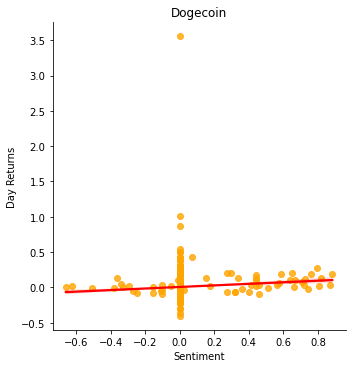

In [97]:
sns.lmplot(x="Sentiment", y="Day Returns", data=DT, scatter_kws={'color': 'orange'}, line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title("Dogecoin")

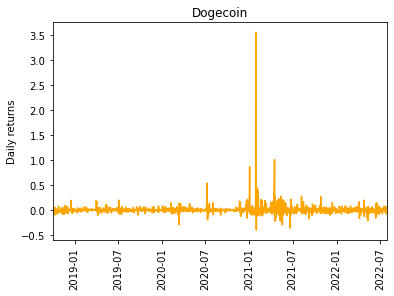

In [98]:
DT_fig = DT[["Date", "dogecoin", "year"]]
DT_fig = DT_fig[DT_fig["dogecoin"]==1]
DT_fig = DT_fig[DT_fig["year"]==2021]

DTdates2021 = DT_fig["Date"].tolist()
DTdates2021 = list(dict.fromkeys(DTdates2021))

DTdate=DT["Date"]
DTdr = DT["Day Returns"]
DTC = DT["dogecoin"]

plt.plot(DTdate,DTdr, color='orange')
 
plt.ylim()
plt.xlim(pd.Timestamp('2018-10-01'),pd.Timestamp('2022-08-01'))
plt.xticks(rotation=90)
plt.ylabel("Daily returns")
plt.title("Dogecoin").get_figure().savefig('DR_dogecoin.png',bbox_inches='tight')

### Both

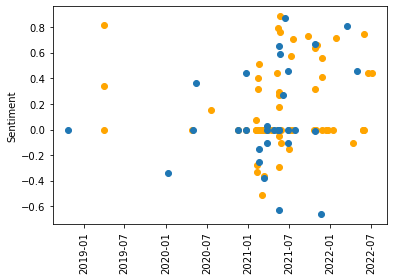

In [99]:
Sen_doge = DT[["Date", "Sentiment", "dogecoin"]]
Sen_doge = Sen_doge[Sen_doge["dogecoin"]==1]

Sen_BTC = BT[["Date", "Sentiment", "bitcoin"]]
Sen_BTC = Sen_BTC[Sen_BTC["bitcoin"]==1]

plt.plot(Sen_doge["Date"],Sen_doge["Sentiment"], linestyle="None", marker='o', color='orange')
plt.plot(Sen_BTC["Date"],Sen_BTC["Sentiment"], linestyle="None", marker='o')
plt.xticks(rotation=90)
plt.ylabel("Sentiment").get_figure().savefig('Sentiment1.png',bbox_inches='tight')

plt.show()

# Descriptiv Statistic 

### Plot of mentions through the year

/var/folders/jp/1kfx9vl50dxdwd42tt3t486w0000gn/T/ipykernel_1228/3293975742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig1['bitcoin']=df_fig1['bitcoin'].replace(0, np.nan)
/var/folders/jp/1kfx9vl50dxdwd42tt3t486w0000gn/T/ipykernel_1228/3293975742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig1['dogecoin']=df_fig1['dogecoin'].replace(0, np.nan)


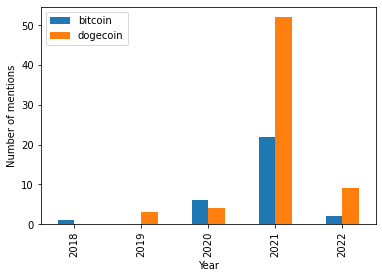

In [104]:
df_fig1 = twit[["year", "bitcoin", "dogecoin"]]

df_fig1['bitcoin']=df_fig1['bitcoin'].replace(0, np.nan)
df_fig1['dogecoin']=df_fig1['dogecoin'].replace(0, np.nan)

df_fig1.groupby(df_fig1['year']).count().plot(kind='bar', ylabel="Number of mentions", xlabel="Year").get_figure().savefig('mentions1.png',bbox_inches='tight')


In [108]:
print(Sen_BTC["Sentiment"].max(), 
      Sen_BTC["Sentiment"].min(),
      Sen_BTC["Sentiment"].mean(),
      Sen_doge["Sentiment"].max(), 
      Sen_doge["Sentiment"].min(),
      Sen_doge["Sentiment"].mean())

0.8689 -0.6597 0.0958741935483871 0.8834 -0.5106 0.16161911764705883


### Bitcoin

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


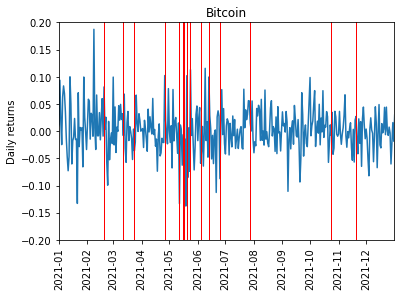

In [100]:
BT_fig = BT[["Date", "bitcoin", "year"]]
BT_fig = BT_fig[BT_fig["bitcoin"]==1]
BT_fig = BT_fig[BT_fig["year"]==2021]

BTdates2021 = BT_fig["Date"].tolist()
BTdates2021 = list(dict.fromkeys(BTdates2021))

BTdate=BT["Date"]
BTdr = BT["Day Returns"]
BTC = BT["bitcoin"]

fig1= plt.plot(BTdate,BTdr)
 
plt.ylim(-0.2,0.2)
plt.xlim(pd.Timestamp('2021-01-01'),pd.Timestamp('2021-12-31'))
plt.xticks(rotation=90)
plt.ylabel("Daily returns")
plt.title("Bitcoin")

for x in BTdates2021:
  print(plt.axvline(pd.Timestamp(x), color='red', linestyle='-', linewidth=1).get_figure().savefig('BT.png',bbox_inches='tight'))

plt.show()

### Dogecoin

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


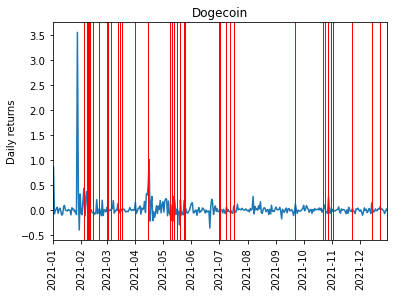

In [101]:
DT_fig = DT[["Date", "dogecoin", "year"]]
DT_fig = DT_fig[DT_fig["dogecoin"]==1]
DT_fig = DT_fig[DT_fig["year"]==2021]

DTdates2021 = DT_fig["Date"].tolist()
DTdates2021 = list(dict.fromkeys(DTdates2021))

DTdate=DT["Date"]
DTdr = DT["Day Returns"]
DTC = DT["dogecoin"]

plot2 = plt.figure(2)
plt.plot(DTdate,DTdr)
 
plt.ylim()
plt.xlim(pd.Timestamp('2021-01-01'),pd.Timestamp('2021-12-31'))
plt.xticks(rotation=90)
plt.ylabel("Daily returns")
plt.title("Dogecoin")

for x in DTdates2021:
  print(plt.axvline(pd.Timestamp(x), color='red', linestyle='-', linewidth=1).get_figure().savefig('DT.png',bbox_inches='tight'))

plt.show()